# Problem Framing: Hospital Billing Prediction

##  Objective
Predict the total **hospital billing amount** using only information available **at or before admission** to enable upfront cost estimates for patients and insurers.

##  Dataset
- **Source**: Synthetic hospital admissions dataset from [OpenDataBay](https://www.opendatabay.com/data/synthetic/953c80ef-162d-467b-ae1c-867d0f9c490d)  
- **Note**: For reproducibility, the data has been downloaded and stored in this project’s `data/` directory as `hospital_admissions.csv`.

##  Problem Type & Target
- **Type**: Supervised Regression  
- **Target Variable**: `Billing_Amount` (continuous, in local currency)

##  Input Features (Admission-Time Only)
To prevent data leakage, features are limited to those known **at the time of admission**:

- **Demographics**: Age, Gender, Blood Type  
- **Clinical**: Primary Medical Condition, Admission Medication, Test Results  
- **Administrative**: Admission Type, Doctor, Hospital, Insurance Provider, Room Number  
- **Temporal**: `Date of Admission` → engineered into day of week, month, or season  

>  **Excluded**: `Discharge Date` and derived `Length of Stay` — these are **not available at prediction time** and would cause **temporal leakage**.

##  Evaluation Strategy
- **Primary Metrics**: RMSE, MAE  
- **Baselines**:  
  - Global mean billing amount  
  - Mean billing per medical condition  
- **Validation**: Time-based train/test split (e.g., train on admissions before 2024, test on 2024+) to mimic real-world deployment

##  Key Considerations
- **No data leakage**: Strictly admission-time features only.  
- **Fairness**: Monitor prediction bias across insurance providers, hospitals, and demographic groups.  
- **Interpretability**: Stakeholders require transparent, auditable predictions.  
- **Clinical relevance**: Billing should correlate with care complexity—not arbitrary attributes like blood type.

## 1. Data Import

* The dataset is hosted on my GitHub repository. To ensure direct and reliable access in this notebook, the file is loaded using the **raw GitHub URL** (not the standard GitHub page link).

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To convert a GitHub file link into a raw file link, you typically replace the part of the URL that says github.com and the path to the file with raw.githubusercontent.com, and remove the blob/ segment from the URL.
# E.g: 

# https://github.com/username/repo/blob/branch/path/to/file.ext

# To:
# https://raw.githubusercontent.com/username/repo/branch/path/to/file.ext



url = "https://raw.githubusercontent.com/Rooney-tech/Machine-Learning/main/Linear%20regression/Data/healthcare_dataset.csv"
hosp_admisn = pd.read_csv(url)

hosp_admisn.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


## 2. Exploratory Data Analysis.

### 2.1 About the data

In [25]:
hosp_admisn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

### 2.2  Data Type & Completeness Overview

-  **No column contains null (missing) values.**  
-  **Numeric columns**:  
  - `'Age'` and `'Room Number'` are stored as integers.  
  - `'Billing Amount'` is stored as a float (appropriate for currency).  
-  **Categorical/text columns**:  
  - All other columns are of `object` (non-numeric) data type.  
-  **Date columns require conversion**:  
  - `'Date of Admission'` and `'Discharge Date'` are currently stored as strings (`object`), **not datetime**.  
  - These must be converted to `datetime` format for temporal feature engineering and time-based validation.  


### 2.2.1 Conversion of '`Date of Admission`' and '`Discharge Date`' to datetime format.

In [26]:
hosp_admisn['Date of Admission'] =hosp_admisn['Date of Admission'].astype(dtype='datetime64[ns]')
hosp_admisn['Discharge Date'] = hosp_admisn['Discharge Date'].astype(dtype='datetime64[ns]')
hosp_admisn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                55500 non-null  object        
 1   Age                 55500 non-null  int64         
 2   Gender              55500 non-null  object        
 3   Blood Type          55500 non-null  object        
 4   Medical Condition   55500 non-null  object        
 5   Date of Admission   55500 non-null  datetime64[ns]
 6   Doctor              55500 non-null  object        
 7   Hospital            55500 non-null  object        
 8   Insurance Provider  55500 non-null  object        
 9   Billing Amount      55500 non-null  float64       
 10  Room Number         55500 non-null  int64         
 11  Admission Type      55500 non-null  object        
 12  Discharge Date      55500 non-null  datetime64[ns]
 13  Medication          55500 non-null  object    

###  Dataset Structure After Type Conversion

The dataset contains **55,500 admission records** with **15 columns** and **no missing values**. Data types are now correctly assigned:

- **Datetime (2)**:  
  - `Date of Admission`  
  - `Discharge Date`  (converted from string)

- **Numeric (3)**:  
  - `Age` (`int64`)  
  - `Room Number` (`int64`)  
  - `Billing Amount` (`float64`)

- **Categorical / Text (10)**:  
  - `Name`, `Gender`, `Blood Type`, `Medical Condition`, `Doctor`, `Hospital`,  
    `Insurance Provider`, `Admission Type`, `Medication`, `Test Results`

#### Dataset Reduction

To optimize memory usage and streamline modeling, we retain only the most relevant features for predicting **`Billing Amount`**. This reduces noise, improves training speed, and minimizes the risk of including spurious or non-actionable variables.

Based on domain knowledge and preliminary analysis, the following admission-time features are selected as the strongest predictors:

- **`Age`**  
- **`Medical Condition`**  
- **`Admission Type`**  
- **`Hospital`**  
- **`Test Results`**  
- **`Medication`**

>  *Rationale*: These variables reflect patient acuity, care setting, and clinical context—all of which directly influence resource utilization and billing. Features like `Name`, `Blood Type`, `Gender`, and `Discharge Date` are excluded due to irrelevance, ethical considerations, or risk of data leakage.

In [27]:
# Drop columns
cols = ['Billing Amount','Age','Medical Condition','Admission Type','Hospital','Test Results','Medication']
admissions = hosp_admisn[cols]
admissions.head()

,Billing Amount,Age,Medical Condition,Admission Type,Hospital,Test Results,Medication
0,18856.281306,30,Cancer,Urgent,Sons and Miller,Normal,Paracetamol
1,33643.327287,62,Obesity,Emergency,Kim Inc,Inconclusive,Ibuprofen
2,27955.096079,76,Obesity,Emergency,Cook PLC,Normal,Aspirin
3,37909.782410,28,Diabetes,Elective,"Hernandez Rogers and Vang,",Abnormal,Ibuprofen
4,14238.317814,43,Cancer,Urgent,White-White,Abnormal,Penicillin


####  Extract categorical variables and examine their data quality.

In [48]:
print('Medical Conditions: ', admissions['Medical Condition'].unique())
print('Admission Types   : ', admissions['Admission Type'].unique())
print('Hospitals         : ', len(admissions['Hospital'].unique()))
print('Test Results      : ', admissions['Test Results'].unique())
print('Medication        : ', admissions['Medication'].unique())


Medical Conditions:  ['Cancer' 'Obesity' 'Diabetes' 'Asthma' 'Hypertension' 'Arthritis']
Admission Types   :  ['Urgent' 'Emergency' 'Elective']
Hospitals         :  39876
Test Results      :  ['Normal' 'Inconclusive' 'Abnormal']
Medication        :  ['Paracetamol' 'Ibuprofen' 'Aspirin' 'Penicillin' 'Lipitor']


* Since the dataset contains 39,876 unique Hospital entries across 55,500 records, most hospitals appear only once or a handful of times. This sparsity prevents the model from generalizing effectively when Hospital is included as a predictor of Billing Amount. Therefore, we exclude this variable entirely from the dataset.


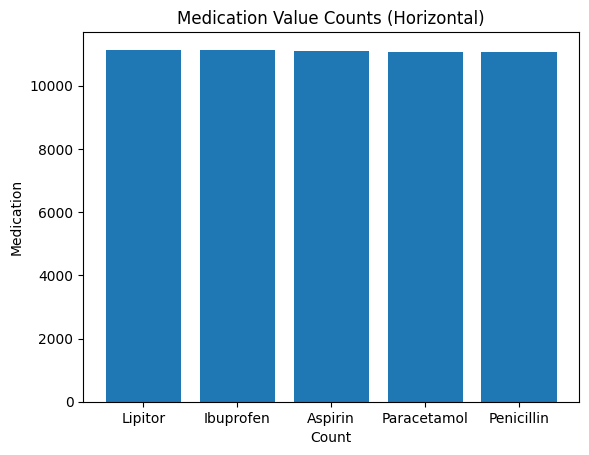

In [ ]:
counts = admissions['Medication'].value_counts()

# Use counts.index for y-axis labels and counts.values for bar widths
plt.bar(x=counts.index, height=counts.values)

# Optional: Add labels and title for better readability
plt.ylabel('Medication')
plt.xlabel('Count')
plt.title('Medication Value Counts (Horizontal)')

# Display the plot
plt.show()



In [71]:
print(admissions['Medical Condition'].value_counts(),'\n')
print(admissions['Admission Type'].value_counts())

Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64 

Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64


### 2.3 Data Visualization

We use a **pairplot** to explore pairwise relationships among numerical features. This helps us:
- Visually assess correlations between variables,  
- Identify potential **multicollinearity** early in the pipeline,  
- Inform feature selection—e.g., by removing one of two highly correlated predictors to improve model stability and interpretability.

In [28]:
# Import visualization libraries.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns